In [13]:
!pip install kagglehub timm --quiet

In [14]:
!pip install -U albumentations

In [15]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import timm
import cv2
import kagglehub
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [16]:
# === Frame Extraction ===
DATASET_PATH = kagglehub.dataset_download("sanikatiwarekar/deep-fake-detection-dfd-entire-original-dataset")
REAL_VIDEOS_PATH = os.path.join(DATASET_PATH, 'DFD_original sequences')
FAKE_VIDEOS_PATH = os.path.join(DATASET_PATH, 'DFD_manipulated_sequences', 'DFD_manipulated_sequences')
FRAME_SAVE_DIR = "/content/frames"
os.makedirs(FRAME_SAVE_DIR, exist_ok=True)

def extract_frames(video_list, label, frame_dir, frames_per_video=5):
    for vid_path in video_list:
        cap = cv2.VideoCapture(vid_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idxs = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
        vid_name = os.path.splitext(os.path.basename(vid_path))[0]
        for idx in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            success, frame = cap.read()
            if success:
                frame_filename = f"{vid_name}_{idx}_{label}.jpg"
                cv2.imwrite(os.path.join(frame_dir, frame_filename), frame)
        cap.release()

real_videos = [os.path.join(REAL_VIDEOS_PATH, f) for f in os.listdir(REAL_VIDEOS_PATH) if f.endswith('.mp4')]
fake_videos = [os.path.join(FAKE_VIDEOS_PATH, f) for f in os.listdir(FAKE_VIDEOS_PATH) if f.endswith('.mp4')]

real_selected = random.sample(real_videos, 50)
fake_selected = random.sample(fake_videos, 50)

extract_frames(real_selected, label="real", frame_dir=FRAME_SAVE_DIR)
extract_frames(fake_selected, label="fake", frame_dir=FRAME_SAVE_DIR)

In [17]:
# === Frame Labeling ===
frame_paths = [os.path.join(FRAME_SAVE_DIR, fname) for fname in os.listdir(FRAME_SAVE_DIR) if fname.endswith('.jpg')]
labels = [0 if 'real' in f else 1 for f in frame_paths]

# === Frame Dataset ===
class DeepfakeFrameDataset(Dataset):
    def __init__(self, frame_paths, labels, transform=None):
        self.frame_paths = frame_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.frame_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(image=img)['image']
        return img, torch.tensor(label, dtype=torch.float32)

In [18]:
# === CNN Feature Extractor ===
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []
        in_channels = 3
        channels = [32, 64, 128, 256, 512]
        for out_channels in channels:
            for _ in range(3):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnn(x)

In [19]:
class ViTHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=2048):
        super().__init__()
        self.cls_token = nn.Parameter(torch.zeros(1, 1, input_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + 16, input_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.mlp_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, 16, 512)  # (B, 49, C)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1)]
        x = self.transformer(x)
        cls_output = x[:, 0]
        return self.mlp_head(cls_output)


In [20]:
# === Combined CViT Model ===
class CViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = CNNFeatureExtractor()
        self.vit_head = ViTHead()

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.vit_head(features)
        return logits

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# === Training ===
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # <<< This ensures both are on GPU
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze(1)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            trues.extend(labels.numpy())
    preds_bin = [1 if p > 0.5 else 0 for p in preds]
    return {
        'accuracy': accuracy_score(trues, preds_bin),
        'f1': f1_score(trues, preds_bin),
        'auc': roc_auc_score(trues, preds)
    }


In [25]:

# === Example Training Script ===
import matplotlib.pyplot as plt
from PIL import Image
train_paths, val_paths, train_labels, val_labels = train_test_split(frame_paths, labels, test_size=0.2, random_state=42)

transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = DeepfakeFrameDataset(train_paths, train_labels, transform=transform)
val_dataset = DeepfakeFrameDataset(val_paths, val_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

history = {'loss': [], 'accuracy': [], 'f1': [], 'auc': []}
for epoch in range(25):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    metrics = evaluate(model, val_loader, device)
    history['loss'].append(loss)
    history['accuracy'].append(metrics['accuracy'])
    history['f1'].append(metrics['f1'])
    history['auc'].append(metrics['auc'])
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, AUC={metrics['auc']:.4f}")




Epoch 1: Loss=0.7260, Accuracy=0.4937, F1=0.6040, AUC=0.5558
Epoch 2: Loss=0.7167, Accuracy=0.5759, F1=0.2637, AUC=0.5635
Epoch 3: Loss=0.7040, Accuracy=0.4430, F1=0.6140, AUC=0.5713
Epoch 4: Loss=0.6995, Accuracy=0.4430, F1=0.6140, AUC=0.5873
Epoch 5: Loss=0.6992, Accuracy=0.5127, F1=0.5792, AUC=0.5765
Epoch 6: Loss=0.6988, Accuracy=0.5823, F1=0.4107, AUC=0.5653
Epoch 7: Loss=0.6965, Accuracy=0.5380, F1=0.5350, AUC=0.5927
Epoch 8: Loss=0.6792, Accuracy=0.5570, F1=0.0000, AUC=0.5036
Epoch 9: Loss=0.6974, Accuracy=0.5443, F1=0.4098, AUC=0.5394
Epoch 10: Loss=0.6935, Accuracy=0.4937, F1=0.6154, AUC=0.5269
Epoch 11: Loss=0.6808, Accuracy=0.5443, F1=0.3455, AUC=0.5442
Epoch 12: Loss=0.6816, Accuracy=0.5696, F1=0.1282, AUC=0.5760
Epoch 13: Loss=0.6881, Accuracy=0.6076, F1=0.3800, AUC=0.6054
Epoch 14: Loss=0.6987, Accuracy=0.5949, F1=0.4074, AUC=0.5539
Epoch 15: Loss=0.6857, Accuracy=0.4430, F1=0.6140, AUC=0.5661
Epoch 16: Loss=0.6881, Accuracy=0.5823, F1=0.4500, AUC=0.5643
Epoch 17: Loss=0.

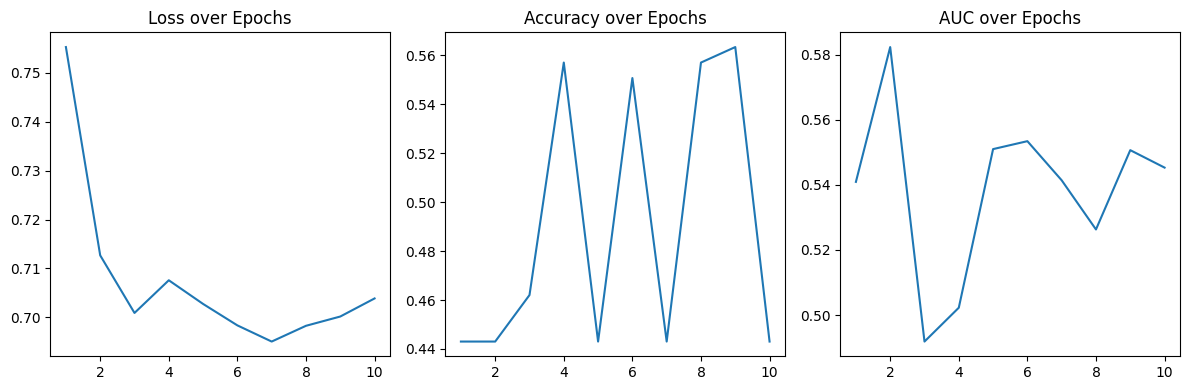

In [23]:
# === Visualize Training Metrics ===
epochs = range(1, 11)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.subplot(1, 3, 2)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.title('Accuracy over Epochs')
plt.subplot(1, 3, 3)
plt.plot(epochs, history['auc'], label='AUC')
plt.title('AUC over Epochs')
plt.tight_layout()
plt.show()

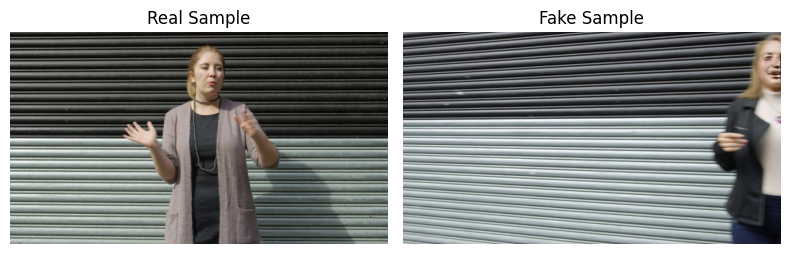

In [24]:
# === Show a Sample Real and Fake Frame ===
from PIL import Image
real_sample = next(p for p in frame_paths if 'real' in p)
fake_sample = next(p for p in frame_paths if 'fake' in p)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(real_sample))
plt.title("Real Sample")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Image.open(fake_sample))
plt.title("Fake Sample")
plt.axis('off')
plt.tight_layout()
plt.show()